<a href="https://colab.research.google.com/github/Rivuozil/Skin-Cancer-Classification-for-Imbalanced-Datasets/blob/main/ISIC_EMB_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Global params


class Globals:
  # @markdown GCP project with GCS bucket of interest:
  gcp_project = 'mineral-liberty-429713-r0'  # @param

  # GCS bucket with data to read:
  gcs_bucket_name = 'isic_2019_images'  # @param

  # @markdown PAD Dataset files:
  # Metadata CSV from PAD dataset to read
  gcs_metadata_csv = '/content/ISIC_2019_Training_GroundTruth_modified.csv'  # @param

  # Images directory:
  gcs_images_dir1 = 'images/ISIC_2019_Training_Input_1'  # @param
  gcs_images_dir2 = 'images/ISIC_2019_Training_Input_2'  # @param
  gcs_images_dir3 = 'images/ISIC_2019_Training_Input_3'  # @param
  gcs_images_dir4 = 'images/ISIC_2019_Training_Input_4'  # @param

  # Column name to use for the small model
  label_column = 'labels'  # @param

  # Column to join the CSV to the images by path
  img_join_column = 'image' # @param

  # @markdown If precomputed embeddings should be used:
  # When true, use precomputed embeddings instead of generating
  # from scratch.
  gcs_use_precomputed_embeddings = False  # @param {type: "boolean"}

  # Path to precomputed embeddings
  gcs_precomputed_embeddings = 'pad_dataset/precomputed/embeddings.npz'  # @param

  # Access Token for `gcs_bucket_name`.
  # Note: You can also manually create and set this
  #   by using `gcloud auth print-access-token` in your local
  #   environment.
  gcs_creds = None

  # @markdown ---
  # @markdown Vertex AI end-point configuration:
  vertex_endpoint_project_id = '132886652110'  # @param
  vertex_endpoint_id = '180'  # @param
  vertex_endpoint_location = 'us-central1'  # @param

  random_state = 3141
  embeddings_size = 6144
  # @markdown ---
  # @markdown Training Parameters--Adjust this to reduce or increase the training size as a % of total training:
  train_split_size = 0.8 # @param
  # Note: this variable sets the training split. We set it by default to 0.15 to show how effective the model is on a small amount of data. You can increase it to see how more data improves the accuracy.

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  metadata_df_dir1 = None
  metadata_df_dir2 = None
  metadata_df_dir3 = None
  metadata_df_dir4 = None
  metadata_df = None


  # Dict from image path -> embedding
  embeddings = dict()

  # pd.DataFrames for training/validation data splits
  df_train = None
  df_validate = None

  # ML model
  model = None

In [ ]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [ ]:
import datetime
import google.auth
import google.auth.transport.requests

Globals.gcs_creds, project = google.auth.default()


def initial_token_refresh():
  # Refresh credentials so an access token is available.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)
  assert (
      Globals.gcs_creds.valid
  ), f'Unexpected error: GCS Credentials are invalid'
  time_until_expiry = (
      Globals.gcs_creds.expiry - datetime.datetime.utcnow()
  ).total_seconds() // 60
  print(
      'Token will expire at'
      f' {Globals.gcs_creds.expiry.strftime("%Y-%m-%d %H:%M:%S")} UTC'
      f' ({time_until_expiry} minutes)'
  )


initial_token_refresh()
print(Globals.gcs_creds)

Token will expire at 2024-08-16 19:32:02 UTC (59.0 minutes)


In [ ]:
# @title Imports

import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time
from typing import List, Text
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tabulate
import tensorflow as tf
import torch

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed) #LYZ: Set Python's hash seed to ensure consistent hashing operations.
    np.random.seed(seed)#Set NumPy’s random seed
    torch.manual_seed(seed)#Set NumPy’s random seed
    torch.cuda.manual_seed(seed)#Set PyTorch's GPU random seed.
    torch.backends.cudnn.deterministic = True# Set to use deterministic algorithms when using CuDNN (GPU-accelerated deep learning library) to ensure repeatability of results.
    torch.backends.cudnn.benchmark = True #Set to enable performance optimization of CuDNN to run faster.

    #LYZ: The call of this function can ensure that operations involving randomness (such as parameter initialization, data enhancement, etc.) are repeatable in different runs of the code.

seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CPU" device.


In [ ]:
classes_to_int_isic = {'MEL':0,'NV':1,'BCC':2, 'AK':3, 'BKL':4, 'DF':5, 'VASC': 6,'SCC': 7}
int_to_classes_isic = {0:'MEL', 1:'NV',2:'BCC', 3:'AK', 4:'BKL', 5:'DF', 6:'VASC', 7:'SCC'}

num_classes=len(int_to_classes_isic.keys())
embedding_dim=6144
batch_size=32
learning_rate=0.001
epochs=40


In [ ]:
from google.cloud import storage


def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)


def load_dataset(bucket, csv_path, images_dir, start_index, end_index):
  """Loads the given CSV into a pd.DataFrame."""
  #images_dir=os.path.join(Globals.gcs_bucket_name,images_dir)
  df = pd.read_csv(Globals.gcs_metadata_csv)
  df['img_path'] = df[Globals.img_join_column].apply(lambda x: os.path.join(images_dir, x))
  df['img_path'] = df['img_path']+".jpg"
  df=df[start_index:end_index]

  return df


Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
#list_blobs(Globals.gcs_storage_client, Globals.gcs_bucket_name)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(Globals.gcs_bucket_name)
print(f'Bucket: {Globals.gcs_bucket.name}')
Globals.metadata_df_dir1 = load_dataset(
    Globals.gcs_bucket, Globals.gcs_metadata_csv, Globals.gcs_images_dir1, 0, 5292
)
Globals.all_col_vals = sorted(set(Globals.metadata_df_dir1[Globals.label_column]))
Globals.metadata_df_dir2 = load_dataset(
   Globals.gcs_bucket, Globals.gcs_metadata_csv, Globals.gcs_images_dir2, 5293, 11892
)
Globals.all_col_vals = sorted(set(Globals.metadata_df_dir2[Globals.label_column]))
Globals.metadata_df_dir3 = load_dataset(
    Globals.gcs_bucket, Globals.gcs_metadata_csv, Globals.gcs_images_dir3, 11893, 16608
)
Globals.all_col_vals = sorted(set(Globals.metadata_df_dir3[Globals.label_column]))
Globals.metadata_df_dir4 = load_dataset(
   Globals.gcs_bucket, Globals.gcs_metadata_csv, Globals.gcs_images_dir4, 16609, 23257
)
Globals.all_col_vals = sorted(set(Globals.metadata_df_dir4[Globals.label_column]))

Globals.metadata_df=pd.concat([Globals.metadata_df_dir1, Globals.metadata_df_dir2, Globals.metadata_df_dir3, Globals.metadata_df_dir4])
Globals.metadata_df.reset_index(drop=True, inplace=True)

Bucket: isic_2019_images


In [ ]:
print(len(Globals.metadata_df))

23254


In [ ]:
# @title Helpers: call Vertex predict
from typing import List
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf import struct_pb2

PredictionServiceClient = aiplatform.gapic.PredictionServiceClient


def create_prediction_service_client_and_endpoint_path():
  client_options = {
      'api_endpoint': (
          f'{Globals.vertex_endpoint_location}-aiplatform.googleapis.com'
      )
  }
  # Initialize client that will be used to create and send requests.
  # This client only needs to be created once, and can be reused for multiple
  # requests.
  client = PredictionServiceClient(client_options=client_options)
  endpoint_path = client.endpoint_path(
      project=Globals.vertex_endpoint_project_id,
      location=Globals.vertex_endpoint_location,
      endpoint=Globals.vertex_endpoint_id,
  )
  return client, endpoint_path


def get_prediction_instances(image_uris: List[str]):
  """Returns a list of JSON dicts to pass as Vertex PredictionService instances."""
  instances = []
  for image_uri in image_uris:
    instance_dict = {
        'bucket_name': Globals.gcs_bucket_name,
        'object_uri': image_uri,
        'bearer_token': Globals.gcs_creds.token,
    }
    instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
    instances.append(instance)
  return instances


def predict(
    client: PredictionServiceClient, endpoint_path: str, image_uris: List[str]
):
  """Calls predict for a Vertex endpoint using the given image paths."""
  instances = get_prediction_instances(image_uris)
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

In [ ]:
%%time
#@title Example predict request
def run_single_predict_request(bucket_name, object_uri):
  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  assert Globals.gcs_creds.token, 'GCS Credential token is not valid. Re-run "Authenticate" section?'
  instance_dict = {
      'bucket_name': bucket_name,
      'object_uri': object_uri,
      'bearer_token': Globals.gcs_creds.token,
  }
  instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
  instances = [instance]
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

# Example of how to run:
TEST_PREDICT_VAL = run_single_predict_request(
    bucket_name=Globals.gcs_bucket_name,
    object_uri='images/ISIC_2019_Training_Input_1/ISIC_0000000.jpg')

# Note: The embedding is in TEST_PREDICT_VAL.predictions
print(TEST_PREDICT_VAL.predictions)
print(TEST_PREDICT_VAL.deployed_model_id)
print(TEST_PREDICT_VAL.model)
print(TEST_PREDICT_VAL.model_display_name)
print(TEST_PREDICT_VAL.model_version_id)

[[0.152157739, 0.0, 0.00703279441, 0.386924177, 0.0, 0.0, 0.0113813141, 0.107516393, 0.0, 0.0030574312, 0.0175601, 0.0, 0.0176910982, 0.0341552161, 0.0, 0.0, 0.00311062485, 0.0, 0.0, 0.00358318444, 0.0, 0.0189469326, 0.39377, 0.0, 0.00237051491, 0.0, 0.0, 0.0, 0.261820048, 0.0, 0.00370986061, 0.0, 0.0183824077, 0.0, 0.0, 0.0, 0.0, 0.01822781, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0164756551, 0.0, 0.0, 0.0464896187, 0.0, 0.0032613962, 0.0157332812, 0.0, 0.0, 0.000338560203, 0.182549432, 0.0190286, 0.0, 0.0, 0.0, 0.0, 0.001276728, 0.0, 0.000110393885, 0.0371686071, 0.0563971847, 0.0564693511, 0.0, 0.0686480254, 0.0, 0.0, 0.00179810286, 1.09953761, 0.00124204939, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00516723655, 0.0201543272, 0.0, 0.0526374392, 0.0, 0.0, 0.0, 0.00387034332, 0.0128183821, 0.0, 0.0, 0.0, 0.0494751036, 0.0, 0.266506165, 0.814559579, 0.0, 0.00280692219, 0.30449453, 0.0, 0.0, 0.0790680945, 0.0, 0.0, 1.09072161, 0.0, 0.265920252, 0.461291373, 0.0, 3.73202348, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
BATCH_COUNTER = collections.Counter()
#@title Generate embeddings concurrently

import concurrent.futures
import time

def refresh_credentials():
  # Refreshing is required b/c this can take longer than the typical 1-hr
  # timeout.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)

def run_predict(client, endpoint_path, img_paths, batch_id=None):
  # Ensure the GCS token has not yet expired. Otherwise `predict`
  # returns `500 Internal Error`.
  if not Globals.gcs_creds.valid:
    refresh_credentials()
    if not Globals.gcs_creds.valid:
      print('GCP Credentials are not valid.')
      return (None, None)
  start = time.time()
  try:
    predictions = predict(client, endpoint_path, img_paths)
  except Exception as e:
    print(f'Error generating embedding for {img_paths}: {e}')
    return (None, None)

  end = time.time()
  return (zip(img_paths, predictions.predictions), end-start, batch_id)


def generate_embeddings_concurrently(df, batch_size=1, num_workers=5):
  """Calls the API to compute embeddings for all images with no embedding yet."""
  # Generate batches of image paths to run the `predict` function with
  all_path_args = []
  for batch_start in np.arange(0, len(df), batch_size):
    batch_df = df.iloc[batch_start:batch_start+batch_size]
    img_paths = list(batch_df['img_path'])
    skip_iteration = True
    for img_path in img_paths:
      if img_path not in Globals.embeddings:
        skip_iteration = False
        break
    if skip_iteration:
      print(f'(skipped) {batch_start}')
      continue
    all_path_args.append(img_paths)

  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  total_embeddings = 0

  # Concurrently run `predict` requests for all image paths.
  overall_start = time.time()
  batch_counter = collections.Counter()
  with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(run_predict, client, endpoint_path, arg, batch_id=i) for i, arg in enumerate(all_path_args)]
    for future in concurrent.futures.as_completed(futures):
      preds, batch_time, batch_id = future.result()
      if preds is not None:
        print(f'{batch_id}: {batch_time}')
        batch_counter[int(batch_time)] += 1
        BATCH_COUNTER[int(batch_time)] += 1
        for img_path, pred in preds:
          Globals.embeddings[img_path] = pred
          total_embeddings += 1
  overall_end = time.time()
  print(f'Total embeddings retrieved: {total_embeddings}')
  print(f'Total time: {overall_end-overall_start}s ({overall_end-overall_start/60.0:.1f})')
  return batch_counter

REQUEST_TIMES = None
if Globals.gcs_use_precomputed_embeddings:
  print(f'WARNING: Skipping calculating embeddings. Precomputed embeddings will be used instead.')
if not Globals.gcs_use_precomputed_embeddings:
  # Note: You can scale up the number of workers after ~10m of making a high
  # volume of API calls.
  REQUEST_TIMES = generate_embeddings_concurrently(missing_metadata_df)

'''
  # Example dictionary
my_dict = Globals.embeddings

# Define the file path in the Colab environment
file_path = '/content/drive/MyDrive/Swarnava/isic_embeddings_1.json'

# Save the dictionary to a JSON file
with open(file_path, 'w') as f:
    json.dump(my_dict, f)

# Define the destination path in your Google Drive
drive_path = '/content/drive/MyDrive/Swarnava/isic_embeddings.json'

# Move the file to Google Drive
!cp /content/my_dict.json "$drive_path"
'''

0: 16.629950284957886
1: 16.83646011352539
2: 17.04049062728882
4: 17.152647018432617
3: 17.16427969932556
5: 7.066028118133545
Total embeddings retrieved: 6
Total time: 23.697749376296997s (1695103464.4)


'\n  # Example dictionary\nmy_dict = Globals.embeddings\n\n# Define the file path in the Colab environment\nfile_path = \'/content/drive/MyDrive/Swarnava/isic_embeddings_1.json\'\n\n# Save the dictionary to a JSON file\nwith open(file_path, \'w\') as f:\n    json.dump(my_dict, f)\n\n# Define the destination path in your Google Drive\ndrive_path = \'/content/drive/MyDrive/Swarnava/isic_embeddings.json\'\n\n# Move the file to Google Drive\n!cp /content/my_dict.json "$drive_path"\n'

In [ ]:
file_path1='/content/drive/MyDrive/Swarnava/{imagesISIC_2019_Training_Input_1IS.txt'
file_path2='/content/drive/MyDrive/Swarnava/{imagesISIC_2019_Training_Input_2IS.txt'
file_path3='/content/drive/MyDrive/Swarnava/{imagesISIC_2019_Training_Input_3IS.txt'
file_path4='/content/drive/MyDrive/Swarnava/isic_embeddings_4.json'

with open(file_path1, 'r', encoding='utf-8') as file:
    data_1=file.read()

data_1=json.loads(data_1)
print(data_1.keys())
with open(file_path2, 'r', encoding='utf-8') as file:
    data_2=file.read()

data_2=json.loads(data_2)
print(data_2.keys())
with open(file_path3, 'r', encoding='utf-8') as file:
    data_3=file.read()

data_3=json.loads(data_3)
print(data_3.keys())

with open(file_path4, 'r') as file:
    data_4=json.load(file)


print(data_4.keys())

embeddings_map=data_1.copy()
embeddings_map.update(data_2)
embeddings_map.update(data_3)
embeddings_map.update(data_4)

print(len(embeddings_map.keys()))




dict_keys(['images/ISIC_2019_Training_Input_1/ISIC_0000003.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000001.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000000.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000002.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000004.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000006.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000007.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000010.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000008.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000009.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000011.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000012.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000014.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000013.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000015.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000016.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000066.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0000067.jpg', 'images/ISIC_2019

In [ ]:
print(Globals.model(next(iter(ISICEmbTrainLoader))[0]).shape) # Should be [batch_size, num_classes]


NameError: name 'ISICEmbTrainLoader' is not defined

In [ ]:
missed_images=[]

for i in range(5292):
    if(Globals.metadata_df_dir1['img_path'][i] not in embeddings_map.keys()):
        missed_images.append(Globals.metadata_df_dir1['img_path'][i])

for i in range(5293, 11892):
    if(Globals.metadata_df_dir2['img_path'][i] not in embeddings_map.keys()):
        missed_images.append(Globals.metadata_df_dir2['img_path'][i])

for i in range(11893, 16608):
    if(Globals.metadata_df_dir3['img_path'][i] not in embeddings_map.keys()):
        missed_images.append(Globals.metadata_df_dir3['img_path'][i])

for i in range(16609, 23256):
    if(Globals.metadata_df_dir4['img_path'][i] not in embeddings_map.keys()):
        missed_images.append(Globals.metadata_df_dir4['img_path'][i])

print(missed_images)

['images/ISIC_2019_Training_Input_1/ISIC_0028765.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0028766.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0028767.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0028768.jpg', 'images/ISIC_2019_Training_Input_2/ISIC_0028770.jpg', 'images/ISIC_2019_Training_Input_2/ISIC_0028771.jpg']


In [ ]:
missing_metadata_df=Globals.metadata_df[Globals.metadata_df['img_path'].isin(missed_images)]

In [ ]:
missing_embeddings=Globals.embeddings
embeddings_map.update(missing_embeddings)

In [ ]:
print(Globals.embeddings.keys())

dict_keys(['images/ISIC_2019_Training_Input_1/ISIC_0028765.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0028766.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0028767.jpg', 'images/ISIC_2019_Training_Input_2/ISIC_0028770.jpg', 'images/ISIC_2019_Training_Input_1/ISIC_0028768.jpg', 'images/ISIC_2019_Training_Input_2/ISIC_0028771.jpg'])


In [ ]:
import json
import numpy as np
from google.protobuf.json_format import MessageToDict

my_dict = Globals.embeddings

# Define the file path in the Colab environment
file_path = '/content/drive/MyDrive/Swarnava/isic_embeddings_missing.json'

# Convert RepeatedComposite objects to NumPy arrays

for key, value in my_dict.items():
    my_dict[key]=list(value)

# Save the dictionary to a JSON file
with open(file_path, 'w') as f:
    json.dump(my_dict, f)

In [ ]:
# Check that we have an embedding for every image
if len(embeddings_map.keys()) < len(Globals.metadata_df)-2:
  raise ValueError(
      f'Expected {len(Globals.metadata_df)-2} embeddings to be present. '
      f'Got {len(embeddings_map.keys())}.\n'
      'Maybe the "Generate embeddings" cell should be run again? This can '
      'happen if there are intermittent API errors.'
  )

In [ ]:
seed=42

from sklearn.model_selection import train_test_split
data=Globals.metadata_df
test_data=pd.DataFrame(columns=Globals.metadata_df.columns)


for class_idx in int_to_classes_isic.keys():
    class_data=Globals.metadata_df[Globals.metadata_df["labels"]==class_idx]
    train_valid_split, test_split=train_test_split(class_data, test_size=0.2, stratify=class_data['labels'], random_state=seed)
    test_data=pd.concat([test_data, test_split])

data=data[~data["image"].isin(test_data["image"])]

train_split,validation_split=train_test_split(data, test_size=0.2, stratify=data["labels"], random_state=seed)
train_split, calib_split=train_test_split(train_split, test_size=0.1, stratify=train_split["labels"], random_state=seed)

train_split.reset_index(drop=True, inplace=True)
validation_split.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
calib_split.reset_index(drop=True, inplace=True)

<ipython-input-20-0c1b5a97b93c>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_data=pd.concat([test_data, test_split])


In [ ]:
train_split.loc[train_split['img_path']=='images/ISIC_2019_Training_Input_4/ISIC_0063663.jpg']

,Unnamed: 0,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,labels,img_path
1640,19272,ISIC_0063663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_4/ISIC_0063663...


In [ ]:
class embDataset(torch.utils.data.Dataset):
    def __init__(self, data, embeddings_map):
        self.data = data
        self.embeddings_map = embeddings_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, id):
        image_path = self.data["img_path"][id]
        parent_folder = image_path.split('/')[-2]


        # Retrieve the embedding for the image path
        emb = self.embeddings_map.get(image_path)
        if emb is None:
            raise ValueError(f"Embedding not found for {image_path}")

        emb = torch.tensor(emb, dtype=torch.float32)

        # Retrieve the label for the image path
        label = torch.as_tensor(
            self.data.loc[self.data["img_path"] == image_path, "labels"].item(),
            dtype=torch.int64
        )

        return emb, label

    def collate_fn(self, batch):
        # Filter out None values (if any)
        batch = [item for item in batch if item is not None]
        emb, labels = list(zip(*batch))
        emb = torch.stack(emb, dim=0).to(device)
        labels = torch.tensor(labels).to(device)
        return emb, labels

# Dataset and DataLoader setup
ISICEmbTrainSet = embDataset(train_split, embeddings_map)
ISICEmbValSet = embDataset(validation_split, embeddings_map)
ISICEmbCalibSet = embDataset(calib_split, embeddings_map)
ISICEmbTestSet = embDataset(test_data, embeddings_map)

ISICEmbTrainLoader = torch.utils.data.DataLoader(
    ISICEmbTrainSet, batch_size=batch_size, shuffle=True, collate_fn=ISICEmbTrainSet.collate_fn
)
ISICEmbValLoader = torch.utils.data.DataLoader(
    ISICEmbValSet, batch_size=batch_size, shuffle=False, collate_fn=ISICEmbValSet.collate_fn
)
ISICEmbCalibLoader = torch.utils.data.DataLoader(
    ISICEmbCalibSet, batch_size=1, shuffle=False, collate_fn=ISICEmbCalibSet.collate_fn
)
ISICEmbTestLoader = torch.utils.data.DataLoader(
    ISICEmbTestSet, batch_size=batch_size, shuffle=False, collate_fn=ISICEmbTestSet.collate_fn
)
ISICEmbTestLoader2 = torch.utils.data.DataLoader(
    ISICEmbTestSet, batch_size=1, shuffle=False, collate_fn=ISICEmbTestSet.collate_fn
)


# Test the DataLoader
for embs, labels in ISICEmbTrainLoader:
    print(embs.shape)
    print(labels.shape)
    break



torch.Size([32, 6144])
torch.Size([32])


In [ ]:
train_split

,Unnamed: 0,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,labels,img_path
0,22929,ISIC_0069423,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,images/ISIC_2019_Training_Input_4/ISIC_0069423...
1,16403,ISIC_0059064,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,images/ISIC_2019_Training_Input_3/ISIC_0059064...
2,10266,ISIC_0031669,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_2/ISIC_0031669...
3,6918,ISIC_0028321,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_1/ISIC_0028321...
4,11610,ISIC_0033013,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_2/ISIC_0033013...
...,...,...,...,...,...,...,...,...,...,...,...,...
15016,11103,ISIC_0032506,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_2/ISIC_0032506...
15017,9990,ISIC_0031393,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_2/ISIC_0031393...
15018,20849,ISIC_0066195,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,images/ISIC_2019_Training_Input_4/ISIC_0066195...
15019,9834,ISIC_0031237,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,images/ISIC_2019_Training_Input_2/ISIC_0031237...


In [ ]:
# @title sklearn LogisticRegression model
from sklearn.linear_model import LogisticRegression
import torch.nn as nn
import torch.optim as optim

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.batchNorm1 = nn.BatchNorm1d(1024)
        self.relu1 = Swish()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.batchNorm2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 256)
        self.batchNorm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 64)
        self.batchNorm4 = nn.BatchNorm1d(64)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.batchNorm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.batchNorm4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

class MLPwithSoftMax(nn.Module):
    def __init__(self,original_model):
        super(MLPwithSoftMax, self).__init__()
        self.base_model=original_model
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.softmax(x)
        return x

Globals.model=MLP(embedding_dim, num_classes)
softmax_model=MLPwithSoftMax(Globals.model).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(Globals.model.parameters(), lr=learning_rate)






In [ ]:
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()

In [ ]:
def train_one_batch(data, model, criterion, optimizer):
    Globals.model.train()
    embs, labels = data

    optimizer.zero_grad()
    out = Globals.model(embs)
    loss = criterion(out, labels)

    loss.backward()
    optimizer.step()

    accuracy = calc_accuracy(out, labels).item()

    return loss.item(), accuracy

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    Globals.model.eval()
    embs, labels = data

    out = Globals.model(embs)
    loss = criterion(out, labels)

    accuracy = calc_accuracy(out, labels)

    return loss.item(), accuracy.item()

In [ ]:

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='/content/drive/MyDrive/Swarnava/isicEmb_model_2.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Initialize best_loss if it's the first call
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)

        # Check if the validation loss has improved enough to consider a checkpoint
        elif self.best_loss - val_loss > self.min_delta:
            self.save_checkpoint(val_loss, model)
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if improvement is seen

        # If no improvement, increase the counter
        else:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves the model when the validation loss decreases."""
        torch.save(Globals.model.state_dict(), self.path)
        print(f'Model saved to: {self.path} with validation loss: {val_loss:.4f}')

In [ ]:
params = {"num_classes": num_classes}

model = Globals.model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, min_lr=1e-7)
stopper = EarlyStopping(patience=5)


In [ ]:
import tqdm

EPOCHS = 40
print_freq = 524


best_valid_loss = float('inf')  # 用于跟踪最佳验证损失

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []


    # code by LYZ:使用 tqdm 来显示训练循环的进度
    for step, batch in tqdm.tqdm(enumerate(ISICEmbTrainLoader, 1), total=len(ISICEmbTrainLoader)):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)

        if step % print_freq == 0:
            print('epoch:', epoch,
                  '\tstep:', step, '/', len(ISICEmbTrainLoader),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')



    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm.tqdm(ISICEmbValLoader)):
        loss, accuracy = validate_one_batch(batch, model, criterion)

        valid_loss.append(loss)
        valid_accs.append(accuracy)

    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

       # code by LYZ:如果验证损失更低，则保存模型权重
    if np.mean(valid_loss) < best_valid_loss:
        best_valid_loss = np.mean(valid_loss)
        checkpoint_path = '/content/drive/MyDrive/Swarnava/isicEmb_model_2.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Model weights saved to {checkpoint_path}')

    stopper(np.mean(valid_loss), model)
    scheduler.step(np.mean(valid_loss))

test_loss_isic, test_accs_isic = [], []
for step, batch in enumerate(tqdm.tqdm(ISICEmbTestLoader)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss_isic.append(loss)
    test_accs_isic.append(accuracy)

print('\ttest loss ISIC :', '{:.4f}'.format(np.mean(test_loss_isic)),
      '\ttest accuracy ISIC', '{:.4f}'.format(np.mean(test_accs_isic)))
'''
test_loss_asan, test_accs_asan = [], []
for step, batch in enumerate(tqdm(test_dl_2)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss_asan.append(loss)
    test_accs_asan.append(accuracy)

print('\ttest loss ASAN:', '{:.4f}'.format(np.mean(test_loss_asan)),
      '\ttest accuracy ASAN', '{:.4f}'.format(np.mean(test_accs_asan)))
'''

100%|██████████| 117/117 [00:04<00:00, 27.64it/s]


epoch: 1 / 40 	train loss: 1.0804 	valid loss: 0.8752 	train accuracy 0.6404 	valid accuracy 0.6947
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.8752


100%|██████████| 117/117 [00:04<00:00, 29.06it/s]


epoch: 2 / 40 	train loss: 0.9019 	valid loss: 0.8229 	train accuracy 0.6894 	valid accuracy 0.7105
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.8229


100%|██████████| 117/117 [00:04<00:00, 28.47it/s]


epoch: 3 / 40 	train loss: 0.8558 	valid loss: 0.7988 	train accuracy 0.7058 	valid accuracy 0.7249
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.7988


100%|██████████| 117/117 [00:04<00:00, 29.21it/s]


epoch: 4 / 40 	train loss: 0.8264 	valid loss: 0.7727 	train accuracy 0.7170 	valid accuracy 0.7281
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.7727


100%|██████████| 117/117 [00:03<00:00, 29.56it/s]


epoch: 5 / 40 	train loss: 0.7968 	valid loss: 0.7671 	train accuracy 0.7215 	valid accuracy 0.7364
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.7671


100%|██████████| 117/117 [00:03<00:00, 29.65it/s]


epoch: 6 / 40 	train loss: 0.7727 	valid loss: 0.7433 	train accuracy 0.7313 	valid accuracy 0.7358
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.7433


100%|██████████| 117/117 [00:04<00:00, 29.07it/s]


epoch: 7 / 40 	train loss: 0.7625 	valid loss: 0.7436 	train accuracy 0.7349 	valid accuracy 0.7407
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:03<00:00, 29.79it/s]


epoch: 8 / 40 	train loss: 0.7360 	valid loss: 0.7309 	train accuracy 0.7408 	valid accuracy 0.7484
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.7309


100%|██████████| 117/117 [00:03<00:00, 29.74it/s]


epoch: 9 / 40 	train loss: 0.7279 	valid loss: 0.7233 	train accuracy 0.7480 	valid accuracy 0.7412
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.7233


100%|██████████| 117/117 [00:03<00:00, 29.44it/s]


epoch: 10 / 40 	train loss: 0.7065 	valid loss: 0.7119 	train accuracy 0.7534 	valid accuracy 0.7476
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.7119


100%|██████████| 117/117 [00:04<00:00, 28.22it/s]


epoch: 11 / 40 	train loss: 0.6880 	valid loss: 0.7138 	train accuracy 0.7548 	valid accuracy 0.7508
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:04<00:00, 27.64it/s]


epoch: 12 / 40 	train loss: 0.6723 	valid loss: 0.7088 	train accuracy 0.7635 	valid accuracy 0.7551
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.7088


100%|██████████| 117/117 [00:03<00:00, 29.58it/s]


epoch: 13 / 40 	train loss: 0.6696 	valid loss: 0.7259 	train accuracy 0.7665 	valid accuracy 0.7444
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:03<00:00, 30.07it/s]


epoch: 14 / 40 	train loss: 0.6540 	valid loss: 0.6978 	train accuracy 0.7735 	valid accuracy 0.7583
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.6978


100%|██████████| 117/117 [00:04<00:00, 25.99it/s]


epoch: 15 / 40 	train loss: 0.6406 	valid loss: 0.7103 	train accuracy 0.7739 	valid accuracy 0.7495
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:04<00:00, 24.06it/s]


epoch: 16 / 40 	train loss: 0.6300 	valid loss: 0.6950 	train accuracy 0.7755 	valid accuracy 0.7593
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.6950


100%|██████████| 117/117 [00:04<00:00, 24.29it/s]


epoch: 17 / 40 	train loss: 0.6141 	valid loss: 0.7098 	train accuracy 0.7845 	valid accuracy 0.7511
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:04<00:00, 23.98it/s]


epoch: 18 / 40 	train loss: 0.6008 	valid loss: 0.6903 	train accuracy 0.7863 	valid accuracy 0.7700
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.6903


100%|██████████| 117/117 [00:04<00:00, 27.68it/s]


epoch: 19 / 40 	train loss: 0.5868 	valid loss: 0.6819 	train accuracy 0.7943 	valid accuracy 0.7639
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.6819


100%|██████████| 117/117 [00:04<00:00, 28.82it/s]


epoch: 20 / 40 	train loss: 0.5732 	valid loss: 0.6835 	train accuracy 0.7950 	valid accuracy 0.7599
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:04<00:00, 27.88it/s]


epoch: 21 / 40 	train loss: 0.5688 	valid loss: 0.6907 	train accuracy 0.7995 	valid accuracy 0.7631
INFO: Early stopping counter 2 of 5


100%|██████████| 117/117 [00:04<00:00, 28.00it/s]


epoch: 22 / 40 	train loss: 0.5519 	valid loss: 0.6764 	train accuracy 0.8058 	valid accuracy 0.7663
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.6764


100%|██████████| 117/117 [00:03<00:00, 29.74it/s]


epoch: 23 / 40 	train loss: 0.5426 	valid loss: 0.6921 	train accuracy 0.8059 	valid accuracy 0.7671
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:04<00:00, 28.64it/s]


epoch: 24 / 40 	train loss: 0.5347 	valid loss: 0.6809 	train accuracy 0.8132 	valid accuracy 0.7695
INFO: Early stopping counter 2 of 5


100%|██████████| 117/117 [00:04<00:00, 28.44it/s]


epoch: 25 / 40 	train loss: 0.5145 	valid loss: 0.6692 	train accuracy 0.8167 	valid accuracy 0.7706
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.6692


100%|██████████| 117/117 [00:03<00:00, 29.48it/s]


epoch: 26 / 40 	train loss: 0.5104 	valid loss: 0.6599 	train accuracy 0.8205 	valid accuracy 0.7719
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.6599


100%|██████████| 117/117 [00:03<00:00, 29.85it/s]


epoch: 27 / 40 	train loss: 0.5052 	valid loss: 0.6699 	train accuracy 0.8201 	valid accuracy 0.7740
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:04<00:00, 29.12it/s]


epoch: 28 / 40 	train loss: 0.4881 	valid loss: 0.6707 	train accuracy 0.8292 	valid accuracy 0.7756
INFO: Early stopping counter 2 of 5


100%|██████████| 117/117 [00:03<00:00, 29.48it/s]


epoch: 29 / 40 	train loss: 0.4819 	valid loss: 0.6651 	train accuracy 0.8288 	valid accuracy 0.7746
INFO: Early stopping counter 3 of 5


100%|██████████| 117/117 [00:04<00:00, 28.55it/s]


epoch: 30 / 40 	train loss: 0.4786 	valid loss: 0.6659 	train accuracy 0.8313 	valid accuracy 0.7730
INFO: Early stopping counter 4 of 5


100%|██████████| 117/117 [00:03<00:00, 30.48it/s]


epoch: 31 / 40 	train loss: 0.4134 	valid loss: 0.6650 	train accuracy 0.8537 	valid accuracy 0.7879
INFO: Early stopping counter 5 of 5
INFO: Early stopping


100%|██████████| 117/117 [00:03<00:00, 29.96it/s]


epoch: 32 / 40 	train loss: 0.3985 	valid loss: 0.6547 	train accuracy 0.8607 	valid accuracy 0.7933
Model weights saved to /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth
Model saved to: /content/drive/MyDrive/Swarnava/isicEmb_model_2.pth with validation loss: 0.6547


100%|██████████| 117/117 [00:03<00:00, 30.67it/s]


epoch: 33 / 40 	train loss: 0.3872 	valid loss: 0.6655 	train accuracy 0.8632 	valid accuracy 0.7895
INFO: Early stopping counter 1 of 5


100%|██████████| 117/117 [00:03<00:00, 29.29it/s]


epoch: 34 / 40 	train loss: 0.3790 	valid loss: 0.6642 	train accuracy 0.8635 	valid accuracy 0.7938
INFO: Early stopping counter 2 of 5


100%|██████████| 117/117 [00:03<00:00, 29.77it/s]


epoch: 35 / 40 	train loss: 0.3693 	valid loss: 0.6658 	train accuracy 0.8681 	valid accuracy 0.7975
INFO: Early stopping counter 3 of 5


100%|██████████| 117/117 [00:04<00:00, 29.13it/s]


epoch: 36 / 40 	train loss: 0.3555 	valid loss: 0.6916 	train accuracy 0.8726 	valid accuracy 0.7927
INFO: Early stopping counter 4 of 5


100%|██████████| 117/117 [00:03<00:00, 30.43it/s]


epoch: 37 / 40 	train loss: 0.3207 	valid loss: 0.6822 	train accuracy 0.8834 	valid accuracy 0.7967
INFO: Early stopping counter 5 of 5
INFO: Early stopping


100%|██████████| 117/117 [00:03<00:00, 30.19it/s]


epoch: 38 / 40 	train loss: 0.3097 	valid loss: 0.7021 	train accuracy 0.8901 	valid accuracy 0.7981
INFO: Early stopping counter 6 of 5
INFO: Early stopping


100%|██████████| 117/117 [00:03<00:00, 29.65it/s]


epoch: 39 / 40 	train loss: 0.2914 	valid loss: 0.7058 	train accuracy 0.8930 	valid accuracy 0.7959
INFO: Early stopping counter 7 of 5
INFO: Early stopping


100%|██████████| 117/117 [00:03<00:00, 30.46it/s]


epoch: 40 / 40 	train loss: 0.2883 	valid loss: 0.7105 	train accuracy 0.8977 	valid accuracy 0.7970
INFO: Early stopping counter 8 of 5
INFO: Early stopping


100%|██████████| 146/146 [00:05<00:00, 27.80it/s]

	test loss ISIC : 0.6935 	test accuracy ISIC 0.8023


"\ntest_loss_asan, test_accs_asan = [], []\nfor step, batch in enumerate(tqdm(test_dl_2)):\n    loss, accuracy = validate_one_batch(batch, model, criterion)\n\n    test_loss_asan.append(loss)\n    test_accs_asan.append(accuracy)\n\nprint('\ttest loss ASAN:', '{:.4f}'.format(np.mean(test_loss_asan)),\n      '\ttest accuracy ASAN', '{:.4f}'.format(np.mean(test_accs_asan)))\n"

In [ ]:
def load_model(model, model_path, num_classes=8):
    model = MLP(embedding_dim, num_classes)
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # 使用CPU加载模型

    # 获取模型的状态字典
    state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint

    # 创建一个新的状态字典，只保留与模型匹配的键
    model_state_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}

    # 加载状态字典到模型中，strict=False 可以处理缺失或意外的键
    model.load_state_dict(state_dict, strict=False)

    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.reset_running_stats()
            m.reset_parameters()

    model.eval()  # 设置模型为评估模式
    return model

# 用法
model_path = '/content/drive/MyDrive/Swarnava/isicEmb_model.pth'  # 指向保存的模型检查点的路径
Globals.model = load_model(Globals.model,model_path)

In [ ]:
for embs, labels in tqdm.tqdm(ISICEmbTestLoader):
    output=softmax_model(embs)
    print(output)

    accuracy = calc_accuracy(output, labels)


    print(labels)
    print(accuracy)



  3%|▎         | 5/146 [00:00<00:06, 22.21it/s]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.5501e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

  5%|▌         | 8/146 [00:00<00:06, 21.50it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 10%|▉         | 14/146 [00:00<00:06, 21.78it/s]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.5315e-36, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6624e-32, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 14%|█▎        | 20/146 [00:00<00:05, 22.68it/s]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 16%|█▌        | 23/146 [00:01<00:05, 22.41it/s]

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 20%|█▉        | 29/146 [00:01<00:05, 21.58it/s]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 22%|██▏       | 32/146 [00:01<00:05, 20.76it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 26%|██▌       | 38/146 [00:01<00:05, 21.08it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 30%|███       | 44/146 [00:02<00:04, 21.53it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 32%|███▏      | 47/146 [00:02<00:04, 21.41it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.7502e-18, 9.9955e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.5494e-04, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 36%|███▋      | 53/146 [00:02<00:04, 21.27it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 40%|████      | 59/146 [00:02<00:04, 21.18it/s]

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 42%|████▏     | 62/146 [00:02<00:03, 21.87it/s]

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0

 47%|████▋     | 68/146 [00:03<00:03, 21.02it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 51%|█████     | 74/146 [00:03<00:03, 21.88it/s]

tensor([[6.1604e-08, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0332e-23, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 53%|█████▎    | 77/146 [00:03<00:03, 20.91it/s]

tensor([[1.0000e+00, 1.2835e-13, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.2145e-31, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.6137e-39, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 57%|█████▋    | 83/146 [00:03<00:03, 20.84it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.2041e-17, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 59%|█████▉    | 86/146 [00:04<00:02, 20.56it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 61%|██████    | 89/146 [00:04<00:02, 20.63it/s]

tensor(0.8750)
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.3938e-37, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4446e-29, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.4232e-

 65%|██████▌   | 95/146 [00:04<00:02, 20.67it/s]

tensor(0.7500)
tensor([[2.0343e-37, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3958e-15, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

 69%|██████▉   | 101/146 [00:04<00:02, 21.25it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 71%|███████   | 104/146 [00:04<00:01, 21.99it/s]

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.0049e-35, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 2.1353e-38, 0.0000e+00, 0.0000e+00,

 73%|███████▎  | 106/146 [00:04<00:01, 21.20it/s]


KeyboardInterrupt: 

In [ ]:
import tqdm

softmax_model=MLPwithSoftMax(Globals.model).to(device)
E_scores=[]
calib_labels=[]

softmax_model=MLPwithSoftMax(Globals.model).to(device)
for emb,label in tqdm.tqdm(ISICEmbCalibLoader):
    emb=emb.to(device)
    output=softmax_model(emb)
    e=output[[0]]
    E_scores.append(e)
    calib_labels.append(label.item())

    emb=emb.cpu()
    del emb
    torch.cuda.empty_cache()




100%|██████████| 1488/1488 [00:05<00:00, 283.52it/s]


In [ ]:
print(len(calib_split))

1488


In [ ]:
E_values = [e[0] for e in E_scores]
for i in range(len(E_values)):
    E_scores[i] = (E_values[i][calib_labels[i]])
    print(E_scores[i])

tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(0., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(0., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1.3114e-40, grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(0.9999, grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(4.8808e-25, grad_fn=<SelectBackward0>)
tensor(0., grad_fn=<SelectBackward0>)
tensor(0., grad_fn=<SelectBackward0>)
tensor(0., grad_fn=<SelectBackward0>)
tensor(2.0599e-43, grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(0., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<Se

In [ ]:
import math
E_scores = torch.tensor(E_scores)
E_sorted, _ = torch.sort(E_scores)
q_hat = math.ceil((1489)*0.2)/1488
E_10 = torch.quantile(E_sorted, q_hat)
print(E_10)
print(q_hat)

tensor(0.)
0.20026881720430106


In [ ]:
for embs, labels in tqdm.tqdm(ISICEmbTestLoader):
    output=softmax_model(embs)
    print(output)

    accuracy = calc_accuracy(output, labels)


    print(labels)
    print(accuracy)

  4%|▍         | 6/146 [00:00<00:04, 28.06it/s]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.5501e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

  8%|▊         | 12/146 [00:00<00:05, 26.12it/s]

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 12%|█▏        | 18/146 [00:00<00:05, 25.43it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 16%|█▋        | 24/146 [00:00<00:04, 25.74it/s]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 21%|██        | 30/146 [00:01<00:04, 26.10it/s]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4479e-09, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 25%|██▍       | 36/146 [00:01<00:04, 26.20it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 29%|██▉       | 42/146 [00:01<00:04, 25.55it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 33%|███▎      | 48/146 [00:01<00:03, 25.91it/s]

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0

 37%|███▋      | 54/146 [00:02<00:03, 26.43it/s]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 41%|████      | 60/146 [00:02<00:03, 26.54it/s]

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 45%|████▌     | 66/146 [00:02<00:03, 26.31it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 49%|████▉     | 72/146 [00:02<00:02, 26.68it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [4.1601e-16, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [4.1331e-13, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 51%|█████▏    | 75/146 [00:02<00:02, 26.06it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [5.2513e-26, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 55%|█████▌    | 81/146 [00:03<00:02, 25.95it/s]

tensor(0.6562)
tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

 60%|█████▉    | 87/146 [00:03<00:02, 26.81it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 64%|██████▎   | 93/146 [00:03<00:02, 25.39it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.7750e-35, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 68%|██████▊   | 99/146 [00:03<00:01, 25.94it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0985e-01, 8.9015e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 72%|███████▏  | 105/146 [00:04<00:01, 25.92it/s]

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 76%|███████▌  | 111/146 [00:04<00:01, 25.49it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 80%|████████  | 117/146 [00:04<00:01, 24.33it/s]

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 1.6935e-17, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,

 84%|████████▍ | 123/146 [00:04<00:00, 25.02it/s]

tensor([[0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0

 86%|████████▋ | 126/146 [00:04<00:00, 24.26it/s]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8330e-26, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.8441e-19, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

 90%|█████████ | 132/146 [00:05<00:00, 23.83it/s]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,

 92%|█████████▏| 135/146 [00:05<00:00, 25.43it/s]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [5.9779e-42, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.3704e-37],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8376e-42, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,

KeyboardInterrupt: 

In [ ]:
label_sets = {num: set() for num in range(len(test_data))}
count = 0
for emb,label in tqdm.tqdm(ISICEmbTestLoader2):
    emb = emb.to(device)
    output = softmax_model(emb)
    sum=0
    for i in range(len(output[0])):
        if(sum<E_10):
            sum+=output[0][i]
            label_sets[count].add(i)
    count+=1

100%|██████████| 4654/4654 [00:18<00:00, 250.27it/s]


In [ ]:
print(label_sets)

difficulty_index = []
empty = []

count=0
empty_count=0
for label_set in label_sets.values():
    if(len(label_set)>1):
        difficulty_index.append(count)
    count+=1

for label_set in label_sets.values():
    if(len(label_set)==0):
        empty.append(empty_count)
    empty_count+=1
print(len(difficulty_index))
print(len(empty))


{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: set(), 14: set(), 15: set(), 16: set(), 17: set(), 18: set(), 19: set(), 20: set(), 21: set(), 22: set(), 23: set(), 24: set(), 25: set(), 26: set(), 27: set(), 28: set(), 29: set(), 30: set(), 31: set(), 32: set(), 33: set(), 34: set(), 35: set(), 36: set(), 37: set(), 38: set(), 39: set(), 40: set(), 41: set(), 42: set(), 43: set(), 44: set(), 45: set(), 46: set(), 47: set(), 48: set(), 49: set(), 50: set(), 51: set(), 52: set(), 53: set(), 54: set(), 55: set(), 56: set(), 57: set(), 58: set(), 59: set(), 60: set(), 61: set(), 62: set(), 63: set(), 64: set(), 65: set(), 66: set(), 67: set(), 68: set(), 69: set(), 70: set(), 71: set(), 72: set(), 73: set(), 74: set(), 75: set(), 76: set(), 77: set(), 78: set(), 79: set(), 80: set(), 81: set(), 82: set(), 83: set(), 84: set(), 85: set(), 86: set(), 87: set(), 88: set(), 89: set(), 90: set(), 91: set(

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.backends.backend_pdf import PdfPages

def plot_multiclass_roc(y_true, y_score, num_classes, class_names, pdf_filename):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")

    # 保存为PDF
    pdf_pages = PdfPages(pdf_filename)
    pdf_pages.savefig()
    pdf_pages.close()

100%|██████████| 146/146 [00:07<00:00, 20.04it/s]


Class MEL - Accuracy: 0.6181, F1 Score: 0.6649, Recall: 0.6181
Class BCC - Accuracy: 0.9243, F1 Score: 0.8882, Recall: 0.9243
Class NV - Accuracy: 0.8632, F1 Score: 0.7852, Recall: 0.8632
Class AK - Accuracy: 0.3563, F1 Score: 0.4321, Recall: 0.3563
Class SCC - Accuracy: 0.5379, F1 Score: 0.5885, Recall: 0.5379
Class DF - Accuracy: 0.3958, F1 Score: 0.5278, Recall: 0.3958
Class VASC - Accuracy: 0.8824, F1 Score: 0.8571, Recall: 0.8824
Class BKL - Accuracy: 0.3333, F1 Score: 0.4038, Recall: 0.3333


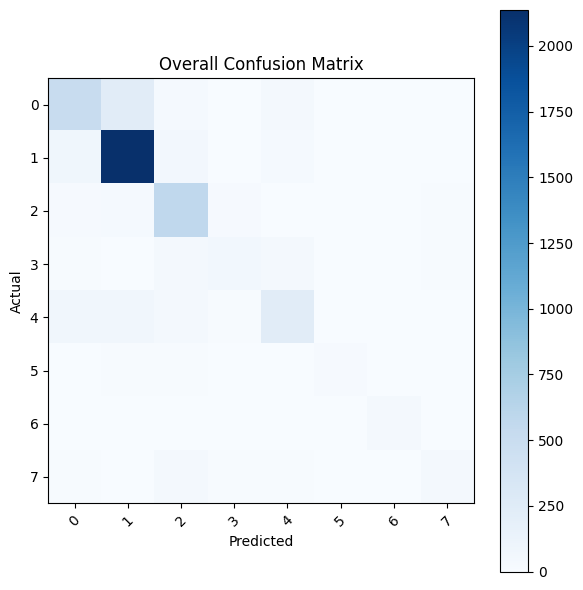

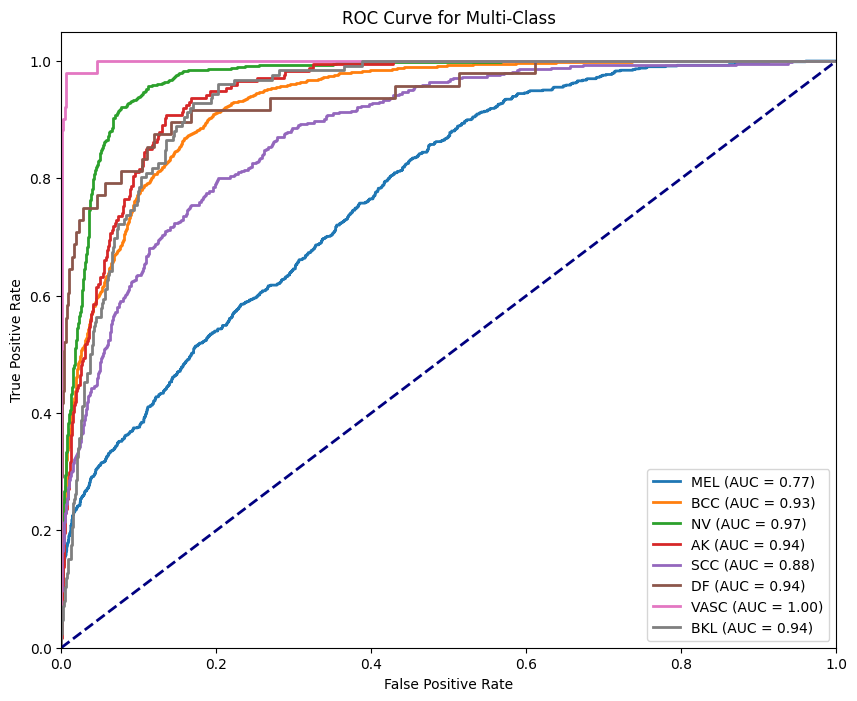

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import label_binarize
import tqdm

@torch.no_grad()
def test_all_classes(model, dataloader):
    model.eval()
    class_correct = [0] * num_classes  # 用于记录每个类别的正确预测数
    class_total = [0] * num_classes  # 用于记录每个类别的总样本数

    all_true_labels = []
    all_pred_labels = []
    all_scores = []  # 存储模型的输出分数矩阵

    confusion_matrices = []  # 存储每个类别的混淆矩阵

    for images, labels in tqdm.tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels = labels.cpu().numpy()
        pred_labels = predicted.cpu().numpy()

        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)


        scores = outputs.cpu().numpy()
        all_scores.extend(scores)


        for i in range(len(labels)):
            label = true_labels[i]
            pred = pred_labels[i]
            class_correct[label] += (pred == label)
            class_total[label] += 1

        # 计算混淆矩阵并添加到列表中
        cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
        confusion_matrices.append(cm)

    # 生成整体混淆矩阵
    overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # 保存整体混淆矩阵为PDF
    pdf_pages_confusion = PdfPages("overall_confusion_matrix.pdf")
    plt.figure(figsize=(6, 6))
    plt.imshow(overall_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Overall Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, np.arange(num_classes), rotation=45)
    plt.yticks(tick_marks, np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    pdf_pages_confusion.savefig()
    pdf_pages_confusion.close()

    for i in range(num_classes):
        class_name = int_to_classes_isic[i]
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0

        # 计算F1分数
        f1 = f1_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        # 计算召回率
        recall = recall_score(all_true_labels, all_pred_labels, labels=[i], average='weighted')

        print(f"Class {class_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    y_true_binary = label_binarize(all_true_labels, classes=np.arange(num_classes))

     # 获取类别名称
    class_names = [int_to_classes_isic[i] for i in range(num_classes)]

    return y_true_binary, np.array(all_scores), class_names



# 调用函数测试所有类别
# 调用函数获取真实标签和模型分数
# 调用函数获取真实标签和模型分数
y_true_binary, scores, class_names = test_all_classes(Globals.model, ISICEmbTestLoader)

# 调用绘制ROC曲线函数
num_classes = 8 # 请确保设置正确的类别数量
# 调用函数绘制多类别ROC曲线并保存为PDF
pdf_filename = "multiclass_roc_curve.pdf"
plot_multiclass_roc(y_true_binary, scores, num_classes, class_names, pdf_filename)